# Deep Learning Summary Notebook

We ran a number of deep learning models. All deep learning models were trained on dataset with 200k samples. In this notebook, we will look at results from our runs and compare results from our traditional ML model with deep learning prototypes

For a list of architectures tested, please see [Architectures Used](#architectures_used)
section of this notebook

All deep learning models use:
* Glove embedding with 300 dimension vectors
    * keep stop words
    * did not lemmatize words
    * remove all HTML tags
    * punchuations are removed
    * contractions are expanded
* max sequence length of 100 words (this is same as what we've been doing)

Based on results for these runs, we will determine which architecture and hyperparameters to use to train the full dataset

### Data Set

The following dataset was used for all of our models:

* 200k samples of pre-processed amazon review body
    * Difference from dataset used in traditional ML model:
        * keep stop words
        * words were not lemmatized

### Criteria for evaluation:

We will use the same custom metric that was using for our traditional ML models so we can use one number to compare between models - this is a harmonic mean of precision for majority classes (5-star) and recall for minority classes (1-star, 2-star, 3-star, and 4-star)

See [Custom Score](#custom_score) section for the code to calculate this metric



NOTES:
* All notebooks used for prototyping were executed on Google Colab. They are located in the [notebooks/deep_learning](https://github.com/sv650s/amazon-review-classification/tree/master/notebooks/deep_learning) directory
* Each notebooks uses ModelWrapper or LSTM1LayerModelWrapper in the [keras_util.py](https://github.com/sv650s/amazon-review-classification/blob/master/util/keras_util.py) class
    * ModelWrapper saves the model files and generate a CSV report used for this notebook. All reports are saved in the [reports](https://github.com/sv650s/amazon-review-classification/tree/master/reports) directory.

    
# Conclusion

Between GRU and LSTM networks, LSTM with balanced weight performed the best out of our deep learning model. Bidirectional GRU performed around the same as our LSTM network with balanced weights. However, training time for GRU is significantly longer. LSTM is a better choice between the two.

Based on 500k samples, our top 3 LSTM configuration had the following. Table also describes our custom score when we train with 1 million samples.

| Rank | Cells | Balanced Weights | Dropout Rate | Recurret Dropout Rate | Batch Size | Learning Rate | Score (1mil) |
|-----|-------|-------------------|--------------|-----------------------|------------|---------------|----------|
| 1st | 128 | Y | 0 | 0.2 | 32 | 0.01 | decrease |
| 2nd | 128 | Y | 0.2 | 0.2 | 128 | 0.01 | increase |
| 3rd | 128 | Y | 0 | 0.2 | 32 | 0.001 | increase |

Since we see a decline in our score when training with larger samples, we will rule out the first model. The 3rd model is also not a great candidate since training time is quite high because of the small batch size and learning rate.

When looking at our custom score vs training time, the 2nd model above is the best candidate as training time decreased by a factor of 3 with minimal decrease of custom score

As we look at more samples (1 million), we see the difference beteween test score and train score decreases for the 2nd model more than the 1st model. This means that as we trian with more examples, the 2nd model is more likely to generalize better.

The configuration we will choose going forward to train our entire dataset will be:

* Cells: 128
* Balanced Weights: True
* Dropout Rate: 0.2
* Recurrent Dropout Rate: 0.2
* Batch Size: 128
* Learning Rate: 0.01
* Max epoch: 20
* Early Stop Patience: 4



In [1]:
# import sibling utilities
import sys
sys.path.append('../')

import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import importlib
import pickle
import os


import util.dict_util as du
import util.report_util as ru
import util.plot_util as pu
import util.keras_util as ku

logging.basicConfig(level=logging.ERROR)

%matplotlib inline
sns.set(font_scale=2)


In [2]:
# load report file form all of our deep learning models
REPORT_DIR = "../reports"
REPORT_FILE = "dl_prototype-report.csv"
report = ru.load_dnn_report(REPORT_DIR, REPORT_FILE, convert_format = True)

<a id='custom_score'></a>
# Custom Score

We are using a harmonic mean of recall for our minority classes (1 to 4 stars) and precision for our majority class (5-star)

In [3]:
??ru.calculate_metric

Signature: ru.calculate_metric(data, column_name='eval_metric', dnn=False) -> pandas.core.frame.DataFrame
Source:   
def calculate_metric(data, column_name ="eval_metric", dnn = False) -> pd.DataFrame:
    """
    Calculates the harmonic mean in the following manner so we can use one metric to evalute our models
        recall - star rating 1, 2, 3, 4
        precision - star rating 5

    :param data: if it's a report df - must have 1_precision, 2_recall, 3_recall, 4_recall, and 5_precision columns.
        Or you can pass in a classification dictionary
    :param column_name: name of column to put metric in. default eval_metric
    :param dnn: indicates if we are calculating this for a DNN notebook as reports have different format
    :return:
    """
    if isinstance(data, pd.DataFrame):
        log.info("Calculating metric for ML report")
        data[column_name] = data.apply(lambda x: _harmonic_mean(
            [ x[col] for col in EVAL_COLS ] ), axis=1)
    elif isinstance(data

In [4]:
??ru._harmonic_mean

Signature: ru._harmonic_mean(values: list)
Source:   
def _harmonic_mean(values: list):
    """
    Calculates the harmonic mean based on a list of values

    if any of the items in the list is 0, function will return 0

    :param values:
    :return:
    """
    mean = 0
    for v in values:
        if v == 0:
            mean = 0
            break
        else:
            mean += 1 / v
    if mean > 0:
        mean = len(values) / mean

    return mean
File:      ~/Dropbox/0_springboard/capstone/util/report_util.py
Type:      function


<a id='architectures_used'></a>
# Architectures Tested

LSTM with balanced weights performed the best compared to GRU. Training time for GRU also takes longer than LSTM

In [5]:
report[["model_name", "architecture", "description", "train_examples"]]

,model_name,architecture,description,train_examples
0,LSTM16,1x16,"1 Layer 16 LSTM Units, unbalanced weights",149653.0
1,LSTMB16,1x16,"1 Layer 16 LSTM Units, balanced weights",149653.0
2,biLSTMB16,1x16,"1 Layer Bidirectional 16 LSTM Units, balanced ...",149653.0
3,GRU16,1x16,"1 Layer 16 GRU units, unbalanced weights",149653.0
4,GRUB16,1x16,"1 Layer 16 GRU units, balanced weights",149653.0
5,biGRUB16,1x16,"1 Layer Bi-directional GRU (16 units), balance...",149653.0
6,CNN32,1x32,"1 Layer CNN with 32 filters, kernel size 3 (un...",149653.0
7,CNNB32,1x32,"1 Layer CNN with 32 filters, kernel size 3 (ba...",149653.0
8,LSTMB128,1x128,"1 Layer 128 LSTM Units, Dropout 0.0, Recurrent...",1683481.0


In [6]:
# load best model from traditional ML model
ML_REPORT_FILE = "201911-pyspark-report.csv"

ml_report = ru.load_dnn_report(REPORT_DIR, ML_REPORT_FILE, convert_format = True)

# flatten out classification report so we can graph later
ml_report = ru.convert_dnn_report_format(ml_report)

ml_best = ru.load_best_from_report(ml_report)

print(f'Score for our best model: {ml_best.iloc[0].eval_metric}')

Score for our best model: 0.5174674207704685


In [7]:
# construct a temporary DF so we can plot the score for our best ML model
ml_plot_df = pd.DataFrame(report.display_name)
ml_plot_df['ml_score'] = ml_best.iloc[0].eval_metric

Best Score: 0.5470530552196904



,display_name,sampling_type,eval_metric,train_examples
0,LSTM16 (1x16),none,0.283666,149653.0
1,LSTMB16 (1x16),none,0.473772,149653.0
2,biLSTMB16 (1x16),none,0.446196,149653.0
3,GRU16 (1x16),none,0.153365,149653.0
4,GRUB16 (1x16),none,0.437440,149653.0
5,biGRUB16 (1x16),none,0.444997,149653.0
6,CNN32 (1x32),none,0.412462,149653.0
7,CNNB32 (1x32),none,0.432567,149653.0
8,LSTMB128 (1x128),none,0.547053,1683481.0


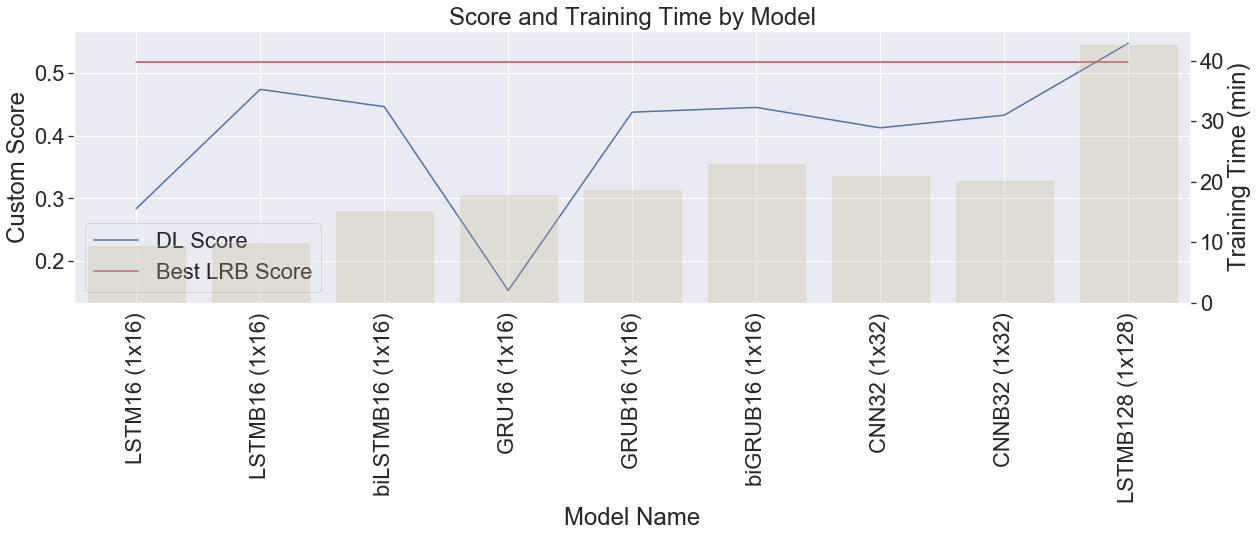

In [8]:
f, a = plt.subplots(1, 1, figsize=(20, 5))
# Plot results from DL models
a = sns.lineplot(data = report, x = "display_name", y = "eval_metric", sort = False, label="DL Score")
# Plot out score from best ML report
a = sns.lineplot(data = ml_plot_df, x = "display_name", y = "ml_score", sort = False, 
                 label="Best LRB Score", linestyle="--", color="r")
_ = plt.xlabel("Model Name")
_ = plt.ylabel("Custom Score")
_ = plt.xticks(rotation=90)

a2 = a.twinx()
_ = sns.barplot(data = report, x = "display_name", 
                y = "train_time_min", 
#                 sort = False, 
                alpha = 0.25,
                ax=a2, 
                label="Training Time", color="y")
_ = plt.ylabel("Training Time (min)")
a2.grid(False)

_ = plt.title("Score and Training Time by Model")


print(f'Best Score: {report.eval_metric.max()}\n')
report[["display_name", "sampling_type", "eval_metric", "train_examples"]]

# Compare Best DL Model (LSTMB) With Logistic Regression (PySpark)

* Logistic Regression Generally has better Precision
* Logistic Regression generally has better Recall with the exception of 3-star ratings

NOTE: Logistic Regression was trained with the full dataset (9 mil samples) whereas for this notebook, all deep learning models were trained with only 200k samples

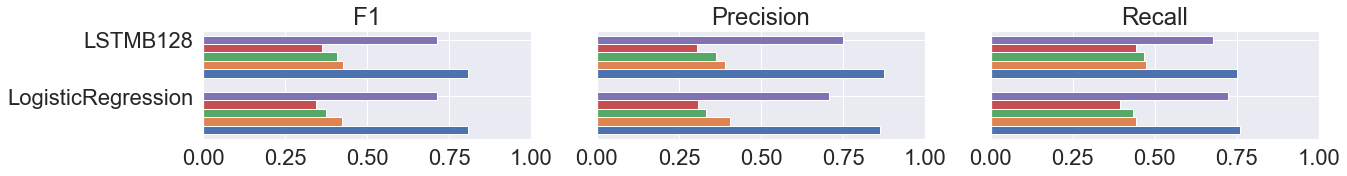

In [9]:
dl_best = ru.load_best_from_report(report)

combined_best = ml_best.append(dl_best, ignore_index=True)
pu.plot_score_histograms(combined_best, version=2, label="model_name", sort=False)


# Compare PySpark Logistic Regression with LSTM

# Testing LSTM with Various Architectures


Constructor to build the model

In [10]:
??ku.LSTM1LayerModelWrapper.__init__

Signature:
ku.LSTM1LayerModelWrapper.__init__(
    self,
    lstm_dim,
    dropout_rate,
    recurrent_dropout_rate,
    bidirectional=False,
    *args,
    **kwargs,
)
Source:   
    def __init__(self,
                 lstm_dim,
                 dropout_rate,
                 recurrent_dropout_rate,
                 bidirectional = False,
                 *args,
                 **kwargs):
        """
        Model wrapper for LSTM networks

        :param lstm_dim:  Number of LSTM cells in the network
        :param dropout_rate: dropout rate
        :param recurrent_dropout_rate:  recurrent dropout rate
        :param bidirectional:  whether network should be bi-directional
        :param args:
        :param kwargs:
        """
        log.debug(f'Constructor LSTM1LayerModelWrapper')

        self.lstm_dim = lstm_dim
        self.bidirectional = bidirectional
        self.dropout_rate = dropout_rate
        self.recurrent_dropout_rate = recurrent_dropout_rate

        super().__ini

In [11]:
??ku.LSTM1LayerModelWrapper.build_model

Signature: ku.LSTM1LayerModelWrapper.build_model(self)
Source:   
    def build_model(self):
        """
        Build a 1 layer LSTM network
        :return: LSTM model
        """
        log.debug(f'Building Model: {self}')

        model = Sequential()
        model.add(self.embedding_layer)
        if self.bidirectional:
            model.add(Bidirectional(LSTM(self.lstm_dim,
                                         dropout = self.dropout_rate,
                                         recurrent_dropout = self.recurrent_dropout_rate)))
        else:
            model.add(LSTM(self.lstm_dim,
                           dropout = self.dropout_rate,
                           recurrent_dropout = self.recurrent_dropout_rate))
        model.add(Dense(5, activation="softmax"))

        model.compile(loss="categorical_crossentropy",
                      optimizer=eval(self.optimizer_name)(learning_rate = self.learning_rate),
                      metrics=["categorical_accuracy"])

       

In [12]:
??ku.ModelWrapper.fit

Signature:
ku.ModelWrapper.fit(
    self,
    X_train,
    y_train,
    epochs,
    validation_split=0.2,
    verbose=1,
    callbacks=None,
    balance_class_weights=True,
    save_checkpoints=False,
)
Source:   
    def fit(self, X_train, y_train,
            epochs,
            validation_split = 0.2,
            verbose = 1,
            callbacks = None,
            balance_class_weights = True,
            # TODO: turn checkpoint back on
            # for larger models, we are getting the following errors:
            # ValueError: Message tensorflow.SavedModel exceeds maximum protobuf size of 2GB: 2966578365
            save_checkpoints = False):
        """
        Calls model.fit and record metrics

        Typical parameters for fit:
            epochs - max epochs for training
            batch_size
            validation_split
            verbose
            callbacks

        :param X_train:
        :param y_train:
        :param epochs:
        :param validation_split:
   

In [13]:
# load report file form all of our deep learning models
REPORT_DIR = "../reports"
REPORT_LR = f'{REPORT_DIR}/201911-pyspark-report.csv'


report_lr = pd.read_csv(REPORT_LR, quotechar="'")
# flatten out classification report so we can graph later
report_lr = ru.convert_dnn_report_format(report_lr)

# calculate our custom score
report_lr["eval_metric"] = report_lr.classification_report.apply(lambda x: ru.calculate_metric(json.loads(x)))


In [14]:
def set_plt_name(df: pd.DataFrame):
    """
    Set plt_name column based on DF values
    
    DF will be edited in place
    
    :param df: dataframe to add plt_name column to
    :return: df with plt_name added
    """
    df["plt_name"] = df.description.apply(lambda x: x.replace("1 Layer ", ""))
    df["plt_name"] = df.plt_name.apply(lambda x: x.replace("LSTM ", ""))
    df["plt_name"] = df.plt_name.apply(lambda x: x.replace("Recurrent Dropout ", "RDR "))
    df["plt_name"] = df.plt_name.apply(lambda x: x.replace("Dropout ", "DR "))
    df["plt_name"] = df.plt_name.apply(lambda x: x.replace("Batch Size ", "BS "))
    df["plt_name"] = df.plt_name.apply(lambda x: x.replace("Learning Rate ", "LR "))
    
    return df


In [15]:


# LSTMB128_DR0_RDR20_BATCH32_LR001
# TODO: retrain 500k samples - 6.9.1.4-LSTMB128-GloVe_with_stop_nonlemmatized-500k-prototype.csv
report_lstmb128_dr0_rdr20_batch32_lr001 = ru.load_dnn_report(REPORT_DIR, 
                                                            'LSTMB128_dr0_rdr2_batch32_lr001-glove_with_stop_nonlemmatized-dl_prototype-report.csv',
                                                           convert_format = True)
report_lstmb128_dr0_rdr20_batch32_lr001 = set_plt_name(report_lstmb128_dr0_rdr20_batch32_lr001)


# LSTMB128_DR0_RDR20_BATCH32_LR01
# 6.9.8.4-LSTMB128_dr0_rdr20_batch128_lr01-glove_with_stop_nonlemmatized-500k-prototype.ipynb
report_lstmb128_dr0_rdr20_batch32_lr01 = ru.load_dnn_report(REPORT_DIR,
                                                            'LSTMB128_dr0_rdr2_batch32_lr01-glove_with_stop_nonlemmatized-dl_prototype-report.csv',
                                                            convert_format = True)
report_lstmb128_dr0_rdr20_batch32_lr01 = set_plt_name(report_lstmb128_dr0_rdr20_batch32_lr01)

# LSTM16_DR0_RDR20_BATCH32_LR001
# 6.9.2.4-LSTMB16_dr0_rdr20_batch32_lr_001-GloVe_with_stop_nonlemmatized-500k-prototype
# report_lstmb16_2
report_lstmb16_dr0_dr20_batch32_lr_001 = ru.load_dnn_report(REPORT_DIR, 
                                                            'LSTMB16_dr0_rdr2_batch32_lr001-glove_with_stop_nonlemmatized-dl_prototype-report.csv',
                                                           convert_format = True)
report_lstmb16_dr0_dr20_batch32_lr_001 = set_plt_name(report_lstmb16_dr0_dr20_batch32_lr_001)





# LSTM16_DR0_RDR20_BATCH128_LR01
# 6.9.11.4-LSTMB128_dr0_rdr20_batch128_lr01-glove_with_stop_nonlemmatized-500k-prototype
# report_lstmb16_2
report_lstmb128_dr0_rdr20_batch128_lr01 = ru.load_dnn_report(REPORT_DIR, 
                                                            'LSTMB128_dr0_rdr2_batch128_lr01-glove_with_stop_nonlemmatized-dl_prototype-report.csv',
                                                           convert_format = True)
report_lstmb128_dr0_rdr20_batch128_lr01 = set_plt_name(report_lstmb128_dr0_rdr20_batch128_lr01)


# LSTM16_DR0_RDR20_BATCH128_LR001
# 6.9.12.4-LSTMB128_dr0_rdr20_batch128_lr001-glove_with_stop_nonlemmatized-500k-prototype.ipynb
# report_lstmb16_2
report_lstmb128_dr0_rdr20_batch128_lr001 = ru.load_dnn_report(REPORT_DIR, 
                                                            'LSTMB128_dr0_rdr2_batch128_lr001-glove_with_stop_nonlemmatized-dl_prototype-report.csv',
                                                           convert_format = True)
report_lstmb128_dr0_rdr20_batch128_lr001 = set_plt_name(report_lstmb128_dr0_rdr20_batch128_lr001)



# LSTM16_DR20_RDR20_BATCH128_LR001
# 6.9.3.4-LSTMB16_dr20_rdr20_batch128_lr001-GloVe_with_stop_nonlemmatized-500k-prototype
report_lstmb16_dr20_rdr20_batch128_lr1001 = ru.load_dnn_report(REPORT_DIR, 
                                                               'LSTMB16_dr2_rdr2_batch128_lr001-glove_with_stop_nonlemmatized-dl_prototype-report.csv',
                                                              convert_format = True)
report_lstmb16_dr20_rdr20_batch128_lr1001 = set_plt_name(report_lstmb16_dr20_rdr20_batch128_lr1001)

# LSTMB128_DR0_RDR0_BATCH32_LR01
# 6.9.9.4-LSTMB128_dr0_rdr0_batch32_lr01-glove_with_stop_nonlemmatized-500k-prototype
report_lstmb128_dr0_rdr0_batch32_lr01 = ru.load_dnn_report(REPORT_DIR, 
                                                               'LSTMB128_dr0_rdr0_batch32_lr01-glove_with_stop_nonlemmatized-dl_prototype-report.csv',
                                                              convert_format = True)
# report_lstmb128_dr0_rdr0_batch32_lr01 = report_lstmb128_dr0_rdr0_batch32_lr01.append(
#     ru.load_dnn_report(REPORT_DIR, 
#                        'paperspace-LSTMB128-1x128-dr0-rdr0-batch32-lr01-glove_with_stop_nonlemmatized-sampling_none-review_body-report.csv', 
#                        convert_format = True), ignore_index = True)
report_lstmb128_dr0_rdr0_batch32_lr01 = set_plt_name(report_lstmb128_dr0_rdr0_batch32_lr01)

# LSTMB128_DR0_RDR0_BATCH32_LR001
# 6.9.10.4-LSTMB128_dr0_rdr0_batch32_lr001-glove_with_stop_nonlemmatized-500k-prototype
report_lstmb128_dr0_rdr0_batch32_lr001 = ru.load_dnn_report(REPORT_DIR, 
                                                               'LSTMB128_dr0_rdr0_batch32_lr001-glove_with_stop_nonlemmatized-dl_prototype-report.csv',
                                                              convert_format = True)
report_lstmb128_dr0_rdr0_batch32_lr001 = set_plt_name(report_lstmb128_dr0_rdr0_batch32_lr001)


# LSTM128_DR0_RDR0_BATCH128_LR01
# 6.9.4.4-LSTMB128_dr0_rdr0_batch128_lr01-GloVe_with_stop_nonlemmatized-500k-prototype
report_lstmb128_dr0_rdr0_batch128_lr01 = ru.load_dnn_report(REPORT_DIR, 
                                                            'LSTMB128_dr0_rdr0_batch128_lr01-glove_with_stop_nonlemmatized-dl_prototype-report.csv',
                                                           convert_format = True)
# report_lstmb128_dr0_rdr0_batch128_lr01 = report_lstmb128_dr0_rdr0_batch128_lr01.append(ru.load_dnn_report(REPORT_DIR, 
#                                                             'paperspace-LSTMB128-1x128-dr0-rdr0-batch128-lr01-glove_with_stop_nonlemmatized-sampling_none-review_body-report.csv',
#                                                            convert_format = True))
report_lstmb128_dr0_rdr0_batch128_lr01 = set_plt_name(report_lstmb128_dr0_rdr0_batch128_lr01)




# LSTM128_DR20_RDR20_BATCH128_LR01
# 6.9.5.4-LSTMB128_dr20_rdr20_batch128_lr01-GloVe_with_stop_nonlemmatized-500k-prototype
report_lstmb128_dr20_rdr20_batch128_lr01 = ru.load_dnn_report(REPORT_DIR, 
                                                              'LSTMB128_dr2_rdr2_batch128_lr01-glove_with_stop_nonlemmatized-dl_prototype-report.csv',
                                                             convert_format = True)
## load paperspace trained report on full dataset
# report_lstmb128_dr20_rdr20_batch128_lr01 = report_lstmb128_dr20_rdr20_batch128_lr01.append(ru.load_dnn_report(REPORT_DIR, 
#                                                               'paperspace-LSTMB128-1x128-dr2-rdr2-batch128-lr01-glove_with_stop_nonlemmatized-sampling_none-review_body-report.csv',
#                                                              convert_format = True), ignore_index = True)
report_lstmb128_dr20_rdr20_batch128_lr01 = set_plt_name(report_lstmb128_dr20_rdr20_batch128_lr01)


# LSTM128_DR20_RDR20_BATCH128_LR001
# 6.9.6.4-LSTMB128_dr20_rdr20_batch128_lr001-GloVe_with_stop_nonlemmatized-500k-prototype.ipynb
report_lstmb128_dr20_rdr20_batch128_lr001 = ru.load_dnn_report(REPORT_DIR, 
                                                               'LSTMB128_dr2_rdr2_batch128_lr001-glove_with_stop_nonlemmatized-dl_prototype-report.csv',
                                                              convert_format = True)
report_lstmb128_dr20_rdr20_batch128_lr001 = set_plt_name(report_lstmb128_dr20_rdr20_batch128_lr001)

# LSTM128_DR20_RDR20_BATCH32_LR001
# 6.9.7.4-LSTMB128_dr20_rdr20_batch32_lr001-GloVe_with_stop_nonlemmatized-500k-prototype.ipynb
report_lstmb128_dr20_rdr20_batch32_lr001 = ru.load_dnn_report(REPORT_DIR, 
                                                              'LSTMB128_dr2_rdr2_batch32_lr001-glove_with_stop_nonlemmatized-dl_prototype-report.csv',
                                                             convert_format = True)
report_lstmb128_dr20_rdr20_batch32_lr001 = set_plt_name(report_lstmb128_dr20_rdr20_batch32_lr001)

# LSTM128_DR0_RDR0_BATCH128_LR001
# 6.9.4.4.1-LSTMB128_dr0_rdr0_batch128_lr001-GloVe_with_stop_nonlemmatized-500k-prototype.ipynb
report_lstmb128_dr0_rdr0_batch128_lr001 = ru.load_dnn_report(REPORT_DIR, 
                                                             'LSTMB128_dr0_rdr0_batch128_lr001-glove_with_stop_nonlemmatized-dl_prototype-report.csv',
                                                            convert_format = True)
report_lstmb128_dr0_rdr0_batch128_lr001 = set_plt_name(report_lstmb128_dr0_rdr0_batch128_lr001)


# Logistic Regression vs LSTM

With just roughly over 100k examples, we are already seeing LSTM surpass performance of Logistic Regression. Roughly at 200k samples, we are starting to see LSTM perform better than Logistic Regression trained with the full dataset

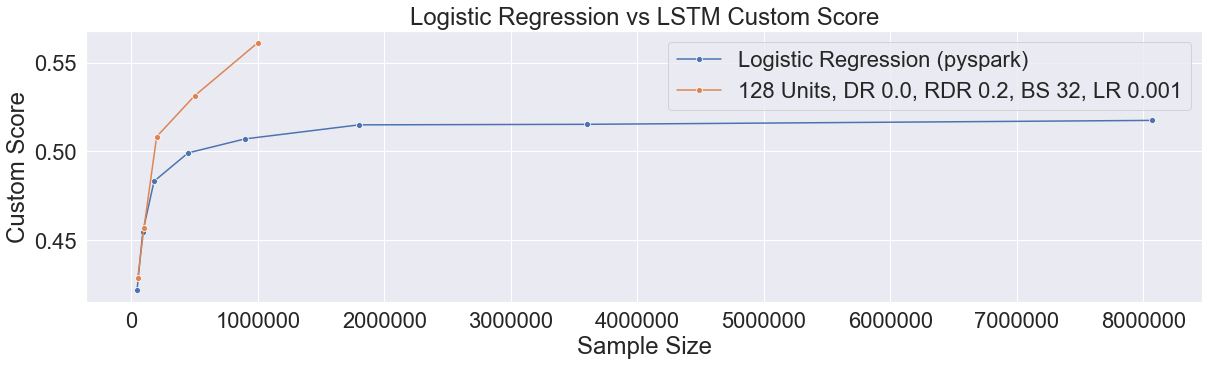

In [16]:
f, a = plt.subplots(1, 1, figsize = (20, 5))
_ = sns.lineplot(data=report_lr, x="train_examples", y="eval_metric", marker="o", label="Logistic Regression (pyspark)", ax=a)
_ = sns.lineplot(data=report_lstmb128_dr0_rdr20_batch32_lr001, x="sample_size", y="eval_metric", marker="o", label=report_lstmb128_dr0_rdr20_batch32_lr001.plt_name.values[0], ax=a)
_ = a.set_title("Logistic Regression vs LSTM Custom Score")
_ = a.set_xlabel("Sample Size")
_ = a.set_ylabel("Custom Score")


# Model Accuracy and Custom Score

### Accuracy

Accuracy = Number of Correct Predictions / Total Number of Predictions

When looking at accuracy, our small LSTM models actually performed better than LR as well as LSTM with 128 cells. However, this is misleading since these models tends to predict results into majority class and does not take into account behavior for minority classes since our sample distribution skews heavily towards 5-star reviews.

We want to look at more granular metric that takes into account recall and precision for various classes to get a better sense of how the models are doing

When looking at accuracy only, it seems like Logistic Regression is performing better compared to some DL models and worse than others. Once we take these into account, you see that LSTM start out performing roughly the same as Logistic Regression with 128 cells. However, it quickly out performs all models with only 500k samples.

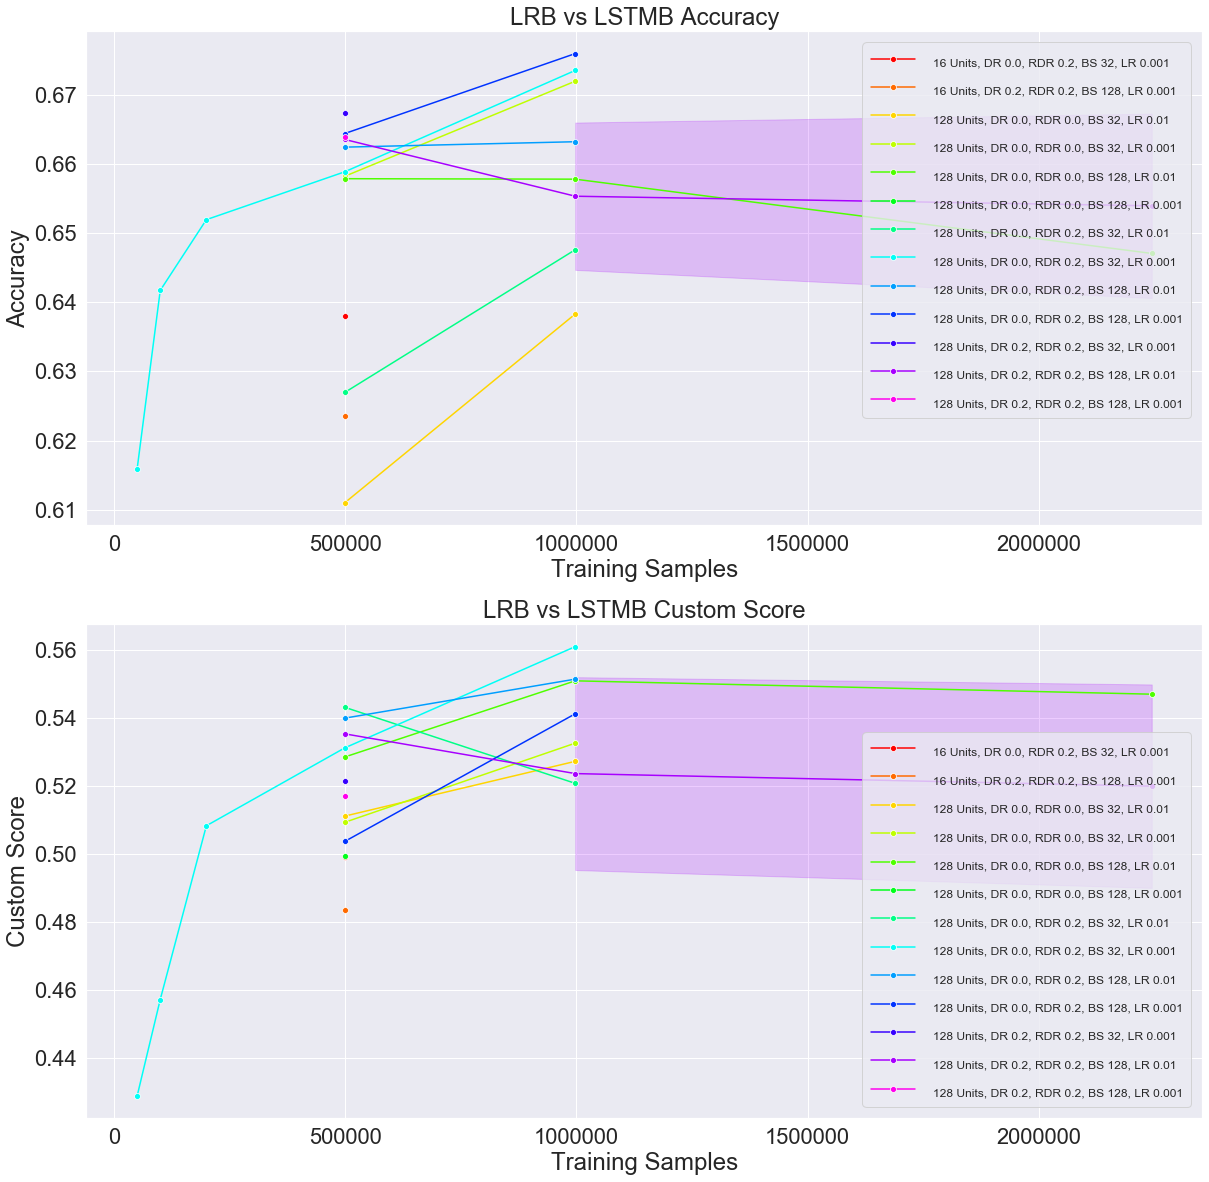

In [17]:
f, a = plt.subplots(2, 1, figsize=(20, 20))

# set unique colors to cycle through
# https://stackoverflow.com/questions/8389636/creating-over-20-unique-legend-colors-using-matplotlib
NUM_COLORS = 14
cm = plt.get_cmap('hsv')
a[0].set_prop_cycle(color = [cm(1. * i/NUM_COLORS) for i in range(NUM_COLORS)])
a[1].set_prop_cycle(color = [cm(1. * i/NUM_COLORS) for i in range(NUM_COLORS)])


# sns.lineplot(data=report_lr, x="train_examples", y="accuracy", marker="o", label="Logistic Regression (pyspark)", ax=a[0])
sns.lineplot(data=report_lstmb16_dr0_dr20_batch32_lr_001, x="sample_size", y="accuracy", marker="o", label=report_lstmb16_dr0_dr20_batch32_lr_001.plt_name.values[0], ax=a[0])
sns.lineplot(data=report_lstmb16_dr20_rdr20_batch128_lr1001, x="sample_size", y="accuracy", marker="o", label=report_lstmb16_dr20_rdr20_batch128_lr1001.plt_name.values[0], ax=a[0])
sns.lineplot(data=report_lstmb128_dr0_rdr0_batch32_lr01, x="sample_size", y="accuracy", marker="o", label=report_lstmb128_dr0_rdr0_batch32_lr01.plt_name.values[0], ax=a[0])
sns.lineplot(data=report_lstmb128_dr0_rdr0_batch32_lr001, x="sample_size", y="accuracy", marker="o", label=report_lstmb128_dr0_rdr0_batch32_lr001.plt_name.values[0], ax=a[0])
sns.lineplot(data=report_lstmb128_dr0_rdr0_batch128_lr01, x="sample_size", y="accuracy", marker="o", label=report_lstmb128_dr0_rdr0_batch128_lr01.plt_name.values[0], ax=a[0])
sns.lineplot(data=report_lstmb128_dr0_rdr0_batch128_lr001, x="sample_size", y="accuracy", marker="o", label=report_lstmb128_dr0_rdr0_batch128_lr001.plt_name.values[0], ax=a[0])
sns.lineplot(data=report_lstmb128_dr0_rdr20_batch32_lr01, x="sample_size", y="accuracy", marker="o", label=report_lstmb128_dr0_rdr20_batch32_lr01.plt_name.values[0], ax=a[0])
sns.lineplot(data=report_lstmb128_dr0_rdr20_batch32_lr001, x="sample_size", y="accuracy", marker="o", label=report_lstmb128_dr0_rdr20_batch32_lr001.plt_name.values[0], ax=a[0])
sns.lineplot(data=report_lstmb128_dr0_rdr20_batch128_lr01, x="sample_size", y="accuracy", marker="o", label=report_lstmb128_dr0_rdr20_batch128_lr01.plt_name.values[0], ax=a[0])
sns.lineplot(data=report_lstmb128_dr0_rdr20_batch128_lr001, x="sample_size", y="accuracy", marker="o", label=report_lstmb128_dr0_rdr20_batch128_lr001.plt_name.values[0], ax=a[0])
sns.lineplot(data=report_lstmb128_dr20_rdr20_batch32_lr001, x="sample_size", y="accuracy", marker="o", label=report_lstmb128_dr20_rdr20_batch32_lr001.plt_name.values[0], ax=a[0])
sns.lineplot(data=report_lstmb128_dr20_rdr20_batch128_lr01, x="sample_size", y="accuracy", marker="o", label=report_lstmb128_dr20_rdr20_batch128_lr01.plt_name.values[0], ax=a[0])
sns.lineplot(data=report_lstmb128_dr20_rdr20_batch128_lr001, x="sample_size", y="accuracy", marker="o", label=report_lstmb128_dr20_rdr20_batch128_lr001.plt_name.values[0], ax=a[0])

report_lstmb128_dr0_rdr0_batch32_lr01

# _ = plt.xticks(rotation=45)
_ = a[0].set_xlabel("Training Samples")
_ = a[0].set_ylabel("Accuracy")
_ = a[0].set_title("LRB vs LSTMB Accuracy")



# sns.lineplot(data=report_lr, x="train_examples", y="eval_metric", marker="o", label="Logistic Regression (pyspark)", ax=a[1])
sns.lineplot(data=report_lstmb16_dr0_dr20_batch32_lr_001, x="sample_size", y="eval_metric", marker="o", label=report_lstmb16_dr0_dr20_batch32_lr_001.plt_name.values[0], ax=a[1])
sns.lineplot(data=report_lstmb16_dr20_rdr20_batch128_lr1001, x="sample_size", y="eval_metric", marker="o", label=report_lstmb16_dr20_rdr20_batch128_lr1001.plt_name.values[0], ax=a[1])
sns.lineplot(data=report_lstmb128_dr0_rdr0_batch32_lr01, x="sample_size", y="eval_metric", marker="o", label=report_lstmb128_dr0_rdr0_batch32_lr01.plt_name.values[0], ax=a[1])
sns.lineplot(data=report_lstmb128_dr0_rdr0_batch32_lr001, x="sample_size", y="eval_metric", marker="o", label=report_lstmb128_dr0_rdr0_batch32_lr001.plt_name.values[0], ax=a[1])
sns.lineplot(data=report_lstmb128_dr0_rdr0_batch128_lr01, x="sample_size", y="eval_metric", marker="o", label=report_lstmb128_dr0_rdr0_batch128_lr01.plt_name.values[0], ax=a[1])
sns.lineplot(data=report_lstmb128_dr0_rdr0_batch128_lr001, x="sample_size", y="eval_metric", marker="o", label=report_lstmb128_dr0_rdr0_batch128_lr001.plt_name.values[0], ax=a[1])
sns.lineplot(data=report_lstmb128_dr0_rdr20_batch32_lr01, x="sample_size", y="eval_metric", marker="o", label=report_lstmb128_dr0_rdr20_batch32_lr01.plt_name.values[0], ax=a[1])
sns.lineplot(data=report_lstmb128_dr0_rdr20_batch32_lr001, x="sample_size", y="eval_metric", marker="o", label=report_lstmb128_dr0_rdr20_batch32_lr001.plt_name.values[0], ax=a[1])
sns.lineplot(data=report_lstmb128_dr0_rdr20_batch128_lr01, x="sample_size", y="eval_metric", marker="o", label=report_lstmb128_dr0_rdr20_batch128_lr01.plt_name.values[0], ax=a[1])
sns.lineplot(data=report_lstmb128_dr0_rdr20_batch128_lr001, x="sample_size", y="eval_metric", marker="o", label=report_lstmb128_dr0_rdr20_batch128_lr001.plt_name.values[0], ax=a[1])
sns.lineplot(data=report_lstmb128_dr20_rdr20_batch32_lr001, x="sample_size", y="eval_metric", marker="o", label=report_lstmb128_dr20_rdr20_batch32_lr001.plt_name.values[0], ax=a[1])
sns.lineplot(data=report_lstmb128_dr20_rdr20_batch128_lr01, x="sample_size", y="eval_metric", marker="o", label=report_lstmb128_dr20_rdr20_batch128_lr01.plt_name.values[0], ax=a[1])
sns.lineplot(data=report_lstmb128_dr20_rdr20_batch128_lr001, x="sample_size", y="eval_metric", marker="o", label=report_lstmb128_dr20_rdr20_batch128_lr001.plt_name.values[0], ax=a[1])



# _ = plt.xticks(rotation=45)
_ = a[1].set_xlabel("Training Samples")
_ = a[1].set_ylabel("Custom Score")
_ = a[1].set_title("LRB vs LSTMB Custom Score")
_ = plt.setp(a[0].get_legend().get_texts(), fontsize='12')
_ = plt.setp(a[1].get_legend().get_texts(), fontsize='12')


# Compare Classification Between Logistic Regression (9 mil) and LSTM with 128 Cells (1 mil)

REMINDER: we are using precision for 1-star and 5-star, and recall for 2-star, 3-star, and 4-star reviews to calculate our custom metric. Tradtionally, we have seen that increasing 2-star recall has been challenging, mostly because we have the least amount of samples available to use for training in this category

* F1 and Precision for LSTM exceeds Logistic Regression for all star ratings
* Recall for LSTM for all star ratings exceed Logistic Regression with the exception of 1-star rating
* Generally, we see precison and recall for all star ratings increase for LSTM as we add more training examples
    * Only exception where we see a recall decline is 1-star ratings after 200k examples
    * Starting at around 500k samples for LSTMB, we are seeing 2-star review recall exceeding 3-star and 4-star recall that we have not seen before. 2-star rating was the lowest of all recalls when we trained with Logistic Regression

Best Logistic Regression Model vs Best LSTM


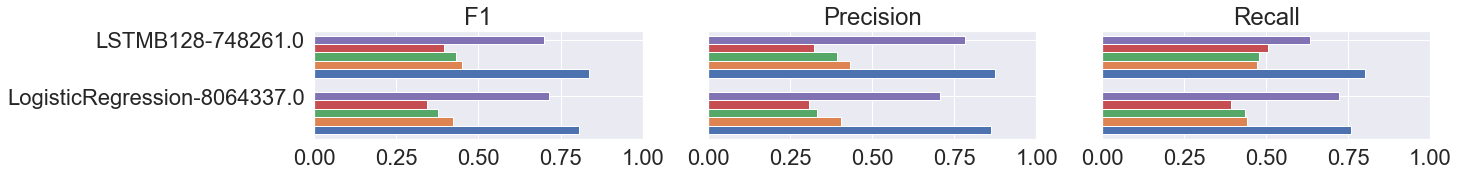

In [18]:
# combine our best LSTM and LR model into one DF so the axis are aligned in our bar graphs
cr_df = report_lstmb128_dr0_rdr20_batch32_lr001[report_lstmb128_dr0_rdr20_batch32_lr001.eval_metric == report_lstmb128_dr0_rdr20_batch32_lr001.eval_metric.max()]. \
                         append(report_lr[report_lr.eval_metric == report_lr.eval_metric.max()], ignore_index = True)
cr_df["display_name"] = cr_df.apply(lambda x: f"{x.model_name}-{str(x.train_examples)}", axis = 1)


print("Best Logistic Regression Model vs Best LSTM")
pu.plot_score_histograms(cr_df, 
                         version=2, 
                         label="display_name")


### Classification Report for LSTMB With 128 Cells

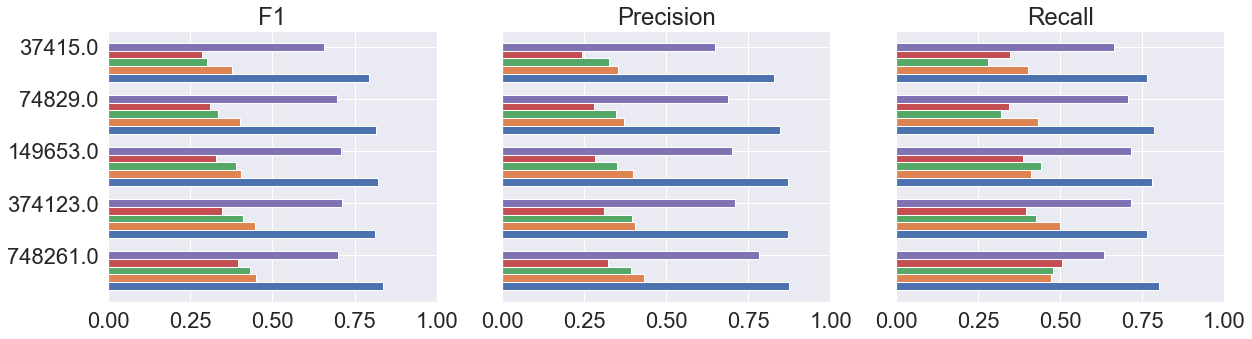

In [19]:
pu.plot_score_histograms(report_lstmb128_dr0_rdr20_batch32_lr001, 
                         version=2, 
                         label="train_examples")

# Hyperparameter Tunning using 500k Total Samples

Here are the results of various runs of LSTM network with various cells and setting

NOTE: all runs used balanced class weights

Key:
* DR = Dropout Rate
* RDR = Recurrent Dropout Rate
* BS = Batch Size
* LR = Learning Rate

Based on training time and custom score on 500k samples the best model to use is:

* 128 LSTM cells
* Dropout Rate: 0.2
* Recurrent Dropout Rate: 0.2
* Learning Rate: 0.01
* Batch Size: 128

There is a slight trade off of score, but training time decreases by a factor of 3


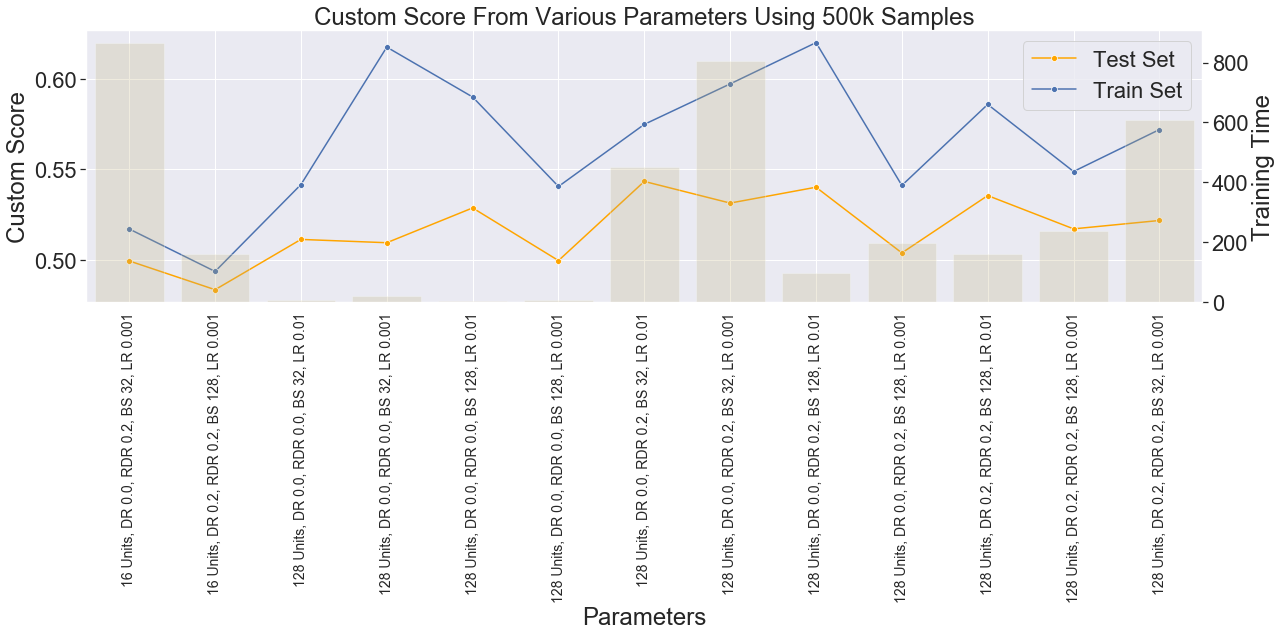

In [20]:

    

pd.set_option('display.max_colwidth', 150)

report_all = report_lstmb16_dr0_dr20_batch32_lr_001.append(report_lstmb16_dr20_rdr20_batch128_lr1001, ignore_index = True). \
                                append(report_lstmb128_dr0_rdr0_batch32_lr01, ignore_index = True). \
                                append(report_lstmb128_dr0_rdr0_batch32_lr001, ignore_index = True). \
                                append(report_lstmb128_dr0_rdr0_batch128_lr01, ignore_index = True). \
                                append(report_lstmb128_dr0_rdr0_batch128_lr001, ignore_index = True). \
                                append(report_lstmb128_dr0_rdr20_batch32_lr01, ignore_index = True). \
                                append(report_lstmb128_dr0_rdr20_batch32_lr001, ignore_index = True). \
                                append(report_lstmb128_dr0_rdr20_batch128_lr01, ignore_index = True). \
                                append(report_lstmb128_dr0_rdr20_batch128_lr001, ignore_index = True). \
                                append(report_lstmb128_dr20_rdr20_batch128_lr01, ignore_index = True). \
                                append(report_lstmb128_dr20_rdr20_batch128_lr001, ignore_index = True). \
                                append(report_lstmb128_dr20_rdr20_batch32_lr001, ignore_index = True)



# keep only 500k total examples results
report_500k = report_all[report_all.train_examples == 374123]
report_500k[["model_name", "description", "eval_metric", "train_time_min", "train_examples"]]

f, a = plt.subplots(1, 1, figsize=(20, 5))
sns.lineplot(data=report_500k, x="plt_name", y="eval_metric", marker="o", sort = False, color = "orange", label = "Test Set")
sns.lineplot(data=report_500k, x="plt_name", y="eval_metric_train", marker="o", sort = False, color = "b", label = "Train Set")

_ = plt.xticks(rotation=90, fontsize=14)
_ = plt.xlabel("Parameters")
_ = plt.ylabel("Custom Score")
_ = plt.title("Custom Score From Various Parameters Using 500k Samples")
# _ = plt.ylim(0, None)

a2 = a.twinx()
a2.grid(False)


_ = sns.barplot(data = report_500k, x = "plt_name", y = "train_time_min", color = "y", alpha = 0.25, ax = a2)
_ = a2.set_ylabel("Training Time")



### Boxplots of Individual Hyperparamters

* 128 cells did better than 16 cells
* smaller batch sizes did better than larger batch sizes (although time to train takes longer)
* the best score came from smaller learning rate, however, on average larger learning rate gave us a better score on average
* no dropout gave us the best score, however, on average setting dropout rate of 0.2 gave us a better score on average
* setting recurrent dropout rate improves score in general

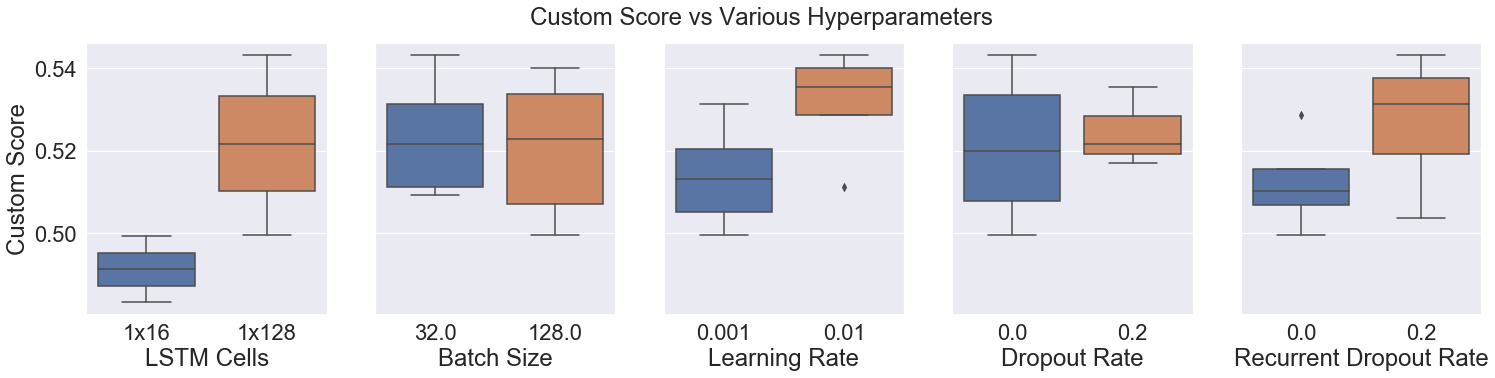

In [21]:
f, a = plt.subplots(1, 5, figsize=(25, 5), sharey= True)
f.suptitle("Custom Score vs Various Hyperparameters", fontsize = 24)

sns.boxplot(data = report_500k, x = "architecture", y = "eval_metric", ax = a[0])
_ = a[0].set_xlabel("LSTM Cells")
_ = a[0].set_ylabel("Custom Score")

sns.boxplot(data = report_500k[report_500k.architecture == "1x128"], x = "batch_size", y = "eval_metric", ax = a[1])
_ = a[1].set_xlabel("Batch Size")
_ = a[1].set_ylabel(None)

sns.boxplot(data = report_500k[report_500k.architecture == "1x128"], x = "learning_rate", y = "eval_metric", ax = a[2])
_ = a[2].set_xlabel("Learning Rate")
_ = a[2].set_ylabel(None)

sns.boxplot(data = report_500k[report_500k.architecture == "1x128"], x = "dropout_rate", y = "eval_metric", ax = a[3])
_ = a[3].set_xlabel("Dropout Rate")
_ = a[3].set_ylabel(None)

sns.boxplot(data = report_500k[report_500k.architecture == "1x128"], x = "recurrent_dropout_rate", y = "eval_metric", ax = a[4])
_ = a[4].set_xlabel("Recurrent Dropout Rate")
_ = a[4].set_ylabel(None)


# Best LSTM Models
## Network History for 500k Samples



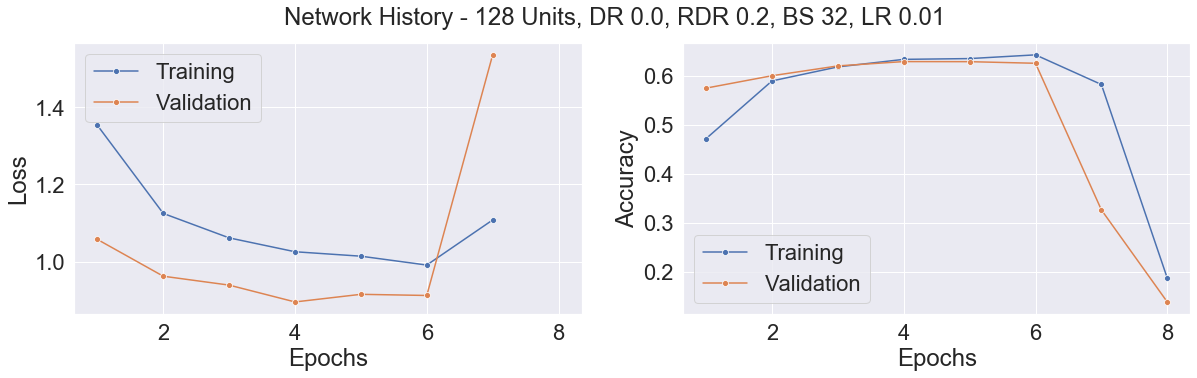

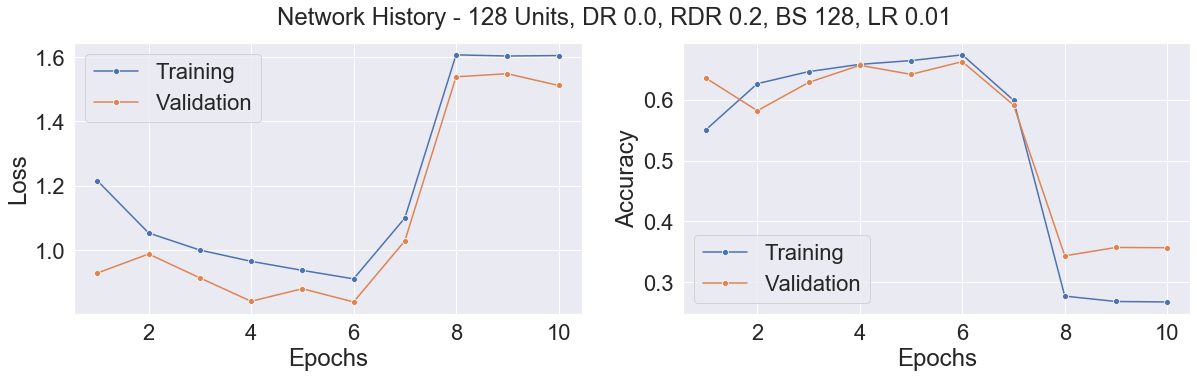

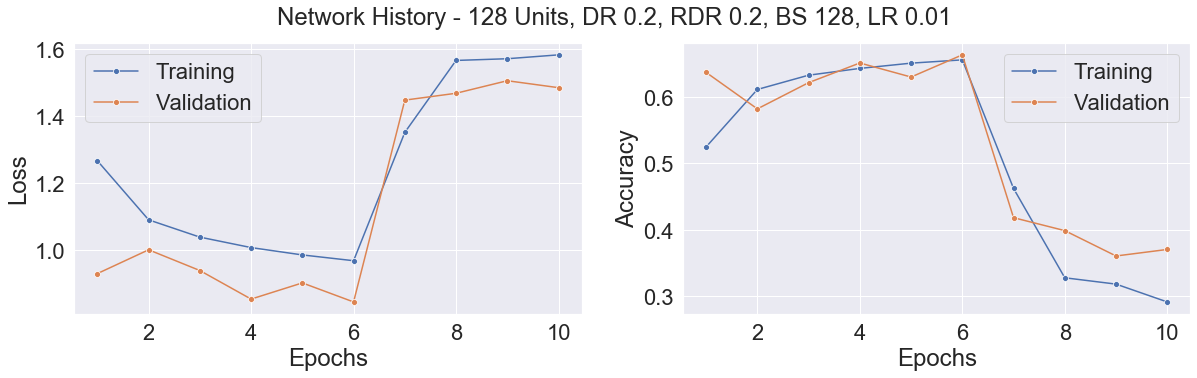

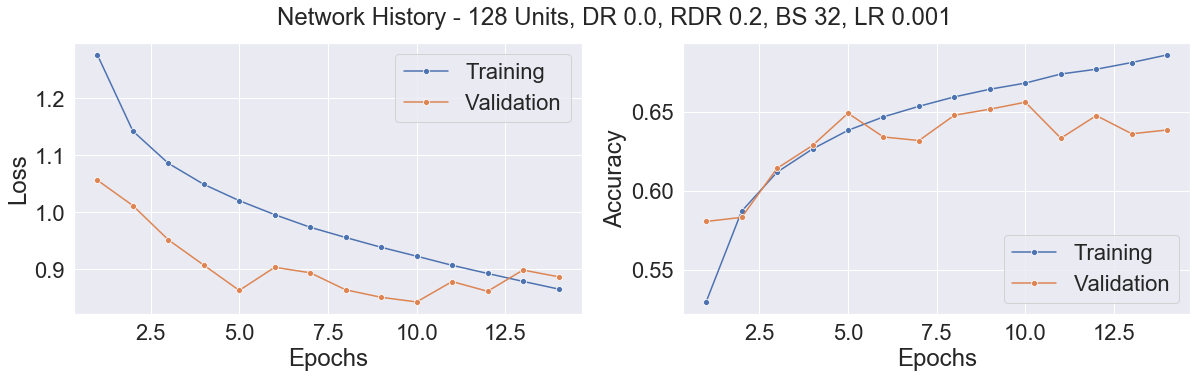

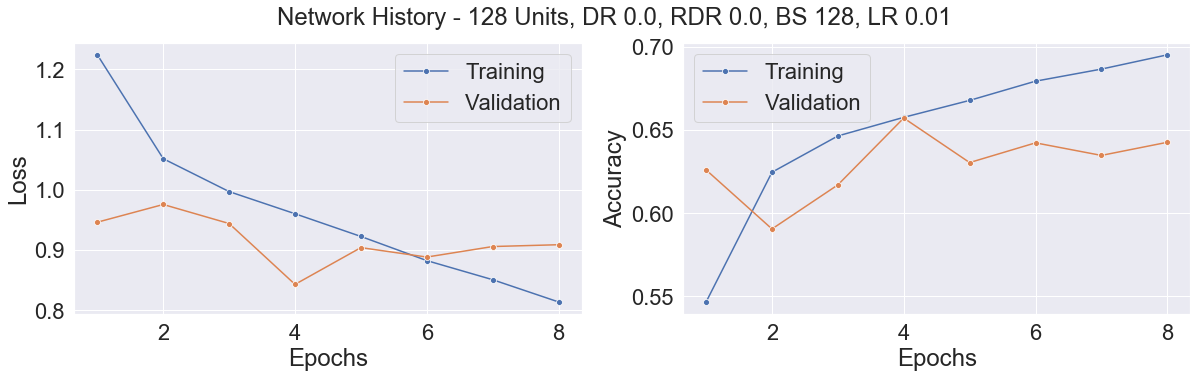

In [22]:
importlib.reload(pu)
BEST = 5

report_500k_best = report_500k.sort_values("eval_metric", ascending = False)[:BEST]


for idx, row in report_500k_best.iterrows():
    
#     print(row.plt_name)
#     print(row.status_date)
#     print(f'network_history: {row.network_history}')
#     print(f'network_history_file: {row.network_history_file}')
#     print(f'history: {row.history}')

    if "network_history" in row.index and row.network_history is not np.NaN and len(row.network_history) > 0:
        network_history = json.loads(row.network_history)
    elif np.notnull(row.network_history_file):
        history_file = f"{REPORT_DIR}/{os.path.basename(row.network_history_file)}"
        if os.path.exists(history_file):
            print(f'Loading from history file: {os.path.basename(history_file)}')
            with open(history_file, 'rb') as file:
                network_history = pickle.load(file)
    else:
        print(f"No network history found for: {row.plt_name}")

    pu.plot_network_history(network_history, 
                            description = row.plt_name,
                            stored_history = True,
                           figsize = (20, 5))

## Training Score vs Test Score

Our best model has batch size of 32 and learning rate of 0.01, the difference between the test set score and training set score increase as we move down the list.

When you look at these models and compare the difference in training scores and test scores, you see that the best model is actually not the best. The difference in these scores for the 2nd model (dropout rate 0.2, recurrent dropout rate 0.2, batch size 128, and learning rate 0.01) actually decreases as we increase sample size, whereas the first model actually increases.

Based on these findings, the model:
* 128 Cell, dropout rate 0.2, recurrent dropout rate 0.2, learning rate 0.01

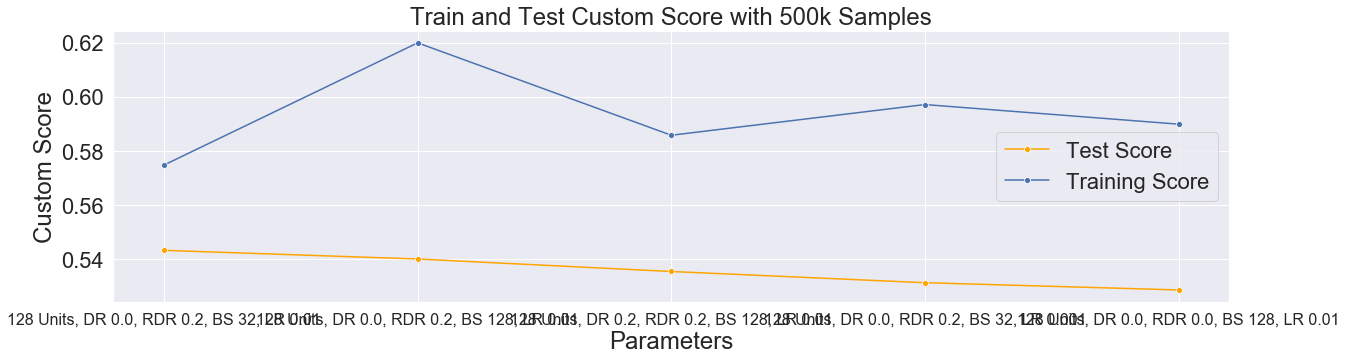

In [23]:

f, a = plt.subplots(1, 1, figsize=(20, 5))

sns.lineplot(data=report_500k_best, x="plt_name", y="eval_metric", marker="o", sort = False, color = "orange", label = "Test Score")
sns.lineplot(data=report_500k_best, x="plt_name", y="eval_metric_train", marker="o", sort = False, color = "b", label = "Training Score")

_ = plt.xticks(fontsize=16)
_ = plt.xlabel("Parameters")
_ = plt.ylabel("Custom Score")
_ = plt.title("Train and Test Custom Score with 500k Samples")


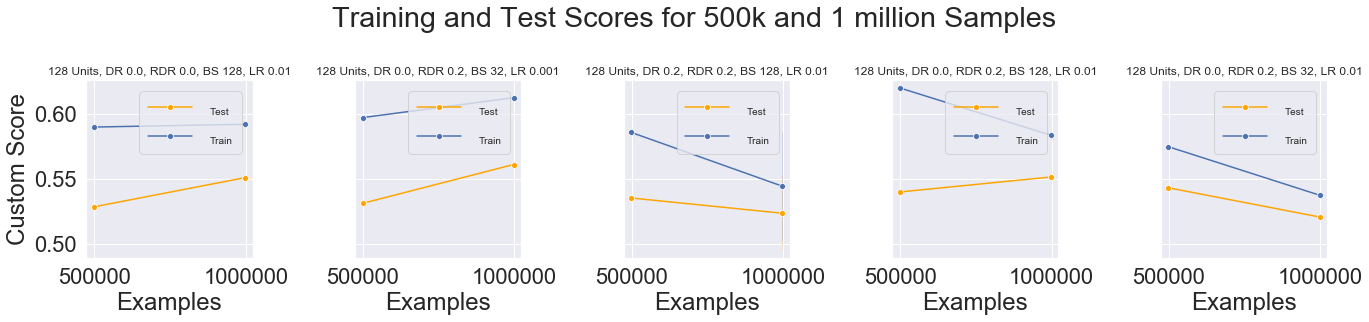

In [24]:
count = BEST - 1

f, a = plt.subplots(1, BEST, figsize=(20, 5), sharey = True)
_ = f.suptitle("Training and Test Scores for 500k and 1 million Samples")
_ = f.tight_layout(pad=3.0)

for idx, row in report_500k_best.iterrows():
    # filter by plt_name and sample sizes
    current = report_all[(report_all.plt_name == row.plt_name) &
                         (report_all.train_examples.isin([374123, 748261]))]
    
    
    sns.lineplot(data = current, 
                 x="sample_size", y="eval_metric", marker="o", sort = False, color = "orange", label = "Test", ax=a[count])
    if current.notnull().values.any():
        sns.lineplot(data = current, 
                     x="sample_size", y="eval_metric_train", marker="o", sort = False, color = "b", label = "Train", ax=a[count])
    _ = a[count].set_title(current.plt_name.values[0], fontsize=12)
    _ = a[count].set_xlabel("Examples")
    _ = a[count].set_ylabel("Custom Score")
    
    _ = plt.setp(a[count].get_legend().get_texts(), fontsize='10')
    
    # iterate this to plot in next subplot
    count -= 1
